# <center> *PyWAsP* tutorial 1 <br><br> From observed wind climate to resource map <center>

<img align="right" src="data/updown.png">

A notebook by the PyWAsP team 

## Introduction

This is an interactive tutorial that will introduce you to the basic WAsP workflow using PyWAsP. 

After completing this tutorial you will be familiar with basic `pywasp` functionality, including:

  - Opening and inspecting wind climate files.
  - Opening and inspecting terrain data
  - Calculating and inspecting site effects from the terrain data
  - Creating a generalized wind climate from  the observed wind climate
  - Creating a resource map by downscaling the generalized wind climate 

As you work your way through the notebook, make sure to run the python code in each cell in the order that they appear. You run the code by clicking on the cell (outlines around the cell should appear) and pressing `<shift> + <enter>` on the keyboard. 

> **__notebook note__** if something looks wrong, or when errors occur, it can be helpful to restart the python kernel via the _kernel_ tab in the top 



## Import packages
Usually the first step when writing a python program is importing standard and external packages we will need. For this analysis we will import `numpy`, `matplotlib`, `xarray`, `pywasp` itself, and some custom code made specificly for this notebook stored in a local file `pywasp_tutorial.py`. 

 - `numpy` is python's main numerical array package https://www.numpy.org/ 
 - `matplotlib` is python's main plotting package https://matplotlib.org/
 - `xarray` is a powerful high level package for labelled multi-dimensional arrays http://xarray.pydata.org
 - `pywasp` docummentation is found at http://docs.wasp.dk/ 
 - `pywasp_tutorial` contains a plotting function that we will use in this tutorial


In [1]:
import warnings
warnings.filterwarnings('ignore')  # We will ignore warnings to avoid cluttering the notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt            
import xarray as xr                       

import pywasp as pw                                            
from pywasp_tutorial import plot_bwc        

It is common to make a short alias of the package when importing using the `import - as -` syntax. The functions and classes of imported packages must be accessed through explicitly typing the package name or alias, e.g. `np.cos(3.14)` will use the cosine function from `numpy`. 

Next, we will use a magic command that makes matplotlib figures appear in the notebook when a plot command is called.

In [2]:
%matplotlib inline                        

## Observed wind climate
 
Now we will import our (observed) binned wind climate from the Høvsøre mast. The data is stored in `hovsore.tab` in the `data` folder. It represents the observed wind climate for the period 2007-2015 at 100 m. above ground level.

> **__pywasp note__**  `pywasp` includes functionality to both read and write wind climate files in many data formats, including ascii (`.tab`), xml (`.owc`), and netCDF (`.nc`). 

The geospatial coordinate in the file is in the [European grid projection](https://en.wikipedia.org/wiki/European_grid#cite_note-1) ([EPSG:3035](https://epsg.io/3035)), which is the recommended projection for high resolution studies in Europe. We will tell `pywasp` this by explicitly passing a keyword argument `srs="EPSG:3035"` to the `open_bwc` call.

In [35]:
bwc = pw.read_bwc('data/hovsore.tab', srs="EPSG:3035")
print(bwc)

<xarray.Dataset>
Dimensions:      (point: 1, sector: 12, wsbin: 30)
Coordinates:
  * wsbin        (wsbin) float64 0.5 1.5 2.5 3.5 4.5 ... 26.5 27.5 28.5 29.5
  * sector       (sector) float64 0.0 30.0 60.0 90.0 ... 240.0 270.0 300.0 330.0
    south_north  (point) float64 3.706e+06
    west_east    (point) float64 4.207e+06
    height       (point) float64 100.0
    wsceil       (wsbin) float64 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0
    crs          int64 0
Dimensions without coordinates: point
Data variables:
    wdfreq       (sector, point) float64 0.02869 0.04459 ... 0.09727 0.0156
    wsfreq       (wsbin, sector, point) float64 0.01167 0.01544 ... 0.0 0.0
    amplif       float64 1.0
    offset       float64 0.0
Attributes:
    header:   Høvsøre observed wind climate EPSG:3035


Notice that the `bwc` object is of type `<xarray.Dataset>` and that it contains four kinds of data:

 1. **Dimensions**: core named dimensions
 2. **Coordinates**: coordinate values along dimensions
 3. **Data variables**: named arrays with data along 0-N named dimensions 
 4. **Attributes**: additional meta data attached to the dataset

> **__xarray note__** the primitive datatype and dimensions of each variable are also shown, along with a small sample of the data. `wsfreq` is a four-dimensional `float64` (double precision) variable along dimensions `(wsbin, sector, height, point)`

Xarray datasets wrap numpy arrays, annotating them with human-readable dimensions and coordinates, and allowing for easy subsetting, data manipulation, and plotting of the underlying data. An `xarray.Dataset` object is a collection of data variables, while each varible itself has type `xarray.DataArray`.

> **__xarray note__** Use the `.values` object attribute to access the underlying numpy array

Beyond the wind speed and wind direction distributions, the wind climate contains information about the height of the measurements (`height`) and the geospatial location (`west_east` and `south_north`), which in this case hold the location information in the projected coordinates of the EPSG:3035 projection.

In the cell below, we will store the location of the Høvsøre mast in variables `loc_x` and `loc_y` for later use.

In [36]:
loc_x = bwc['west_east']    
loc_y = bwc['south_north']

The next step is to plot the wind rose and wind speed distributions in the binned wind climate. For convinience a plotting function `plot_bwc` has been implemented in `pywasp_tutorial` that will do this.

> **notebook note**: you can view the documentation for a function in jupyter notebooks by placing a `?` in front of the function, and you can get the entire function by using `??`.

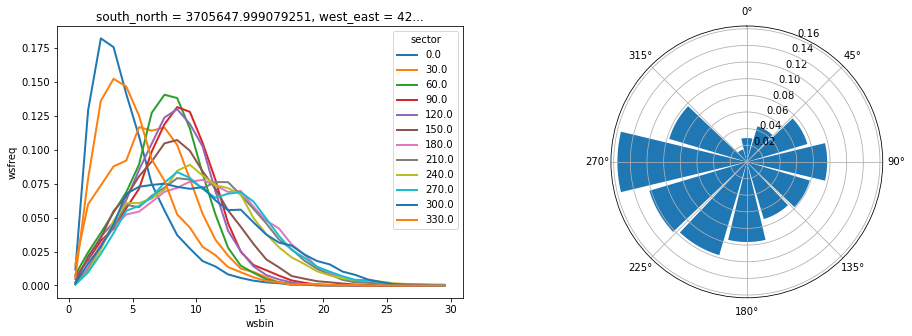

In [37]:
plot_bwc(bwc);

As expected the prevailing wind direction at Høvsøre is from west, while the wind sector with the greatest relative wind speeds is the sector centered on `300.0` degrees and the lowest relative wind speeds comes from due north.  

## Topography data

Now that we have inspected the wind climate, the next step is to load and inspect the terrain data.

### Terrain data (SRTM)

For this tutorial we have provided SRTM elevation data near Høvsøre in a geoTIFF file elev.tif. We will use pywasp to open this dataset with the `read_rastermap` command, telling pywasp that we are reading in a "elevation" raster type.

In [38]:
elev = pw.read_rastermap('data/elev.tif', map_type='elevation')
print(elev)

<xarray.DataArray 'elevation' (south_north: 800, west_east: 800)>
array([[ 0.,  0.,  0., ..., 51., 51., 49.],
       [ 0.,  0.,  0., ..., 52., 53., 53.],
       [ 0.,  0.,  0., ..., 50., 51., 51.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * south_north  (south_north) float64 56.11 56.11 56.11 ... 56.77 56.77 56.77
  * west_east    (west_east) float64 7.818 7.818 7.819 ... 8.482 8.483 8.483
    crs          int64 0
Attributes:
    long_name:      Terrain Elevation
    units:          m
    standard_name:  ground_level_altitude
    grid_mapping:   crs


Notice that while the bwc object was a collection of variables (<xarray.Dataset>), elev is a single data variable of type xarray.DataArray.

The elevation data is provided as a raster defined in the World Geodetic System 1984 (latitude, longitude) projection (EPSG:4326).

To get our elevation data into the local projection several approaches can be used in pywasp. Here we will reproject the data onto a new raster via interpolation using the `warp` function from pywasp.spatial. Because the reprojected raster contains missing data along the edges clip is used to trim the raster to a smaller area containing no missing values.


In [39]:
elev = pw.spatial.warp(elev, to_crs='EPSG:3035')  # Reproject to new raster in EPSG:3035
bounds = (4187500, 3686000, 4226500, 3725000)  # Bounds to trim to
elev = pw.spatial.clip(elev, bounds)  # Trim data
print(elev)

<xarray.DataArray 'elevation' (south_north: 520, west_east: 520)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 28., 27., 22.],
       [ 0.,  0.,  0., ..., 29., 27., 22.],
       [ 0.,  0.,  0., ..., 29., 27., 22.]])
Coordinates:
    crs          int64 0
  * south_north  (south_north) float64 3.725e+06 3.725e+06 ... 3.686e+06
  * west_east    (west_east) float64 4.188e+06 4.188e+06 ... 4.226e+06 4.226e+06


Lets visualize the elevation data. To plot it on a map, we will use the builtin `plot` method of `xarray.DataArray`. We will  use the `terrain` colormap, bound the values between `-11` and `50`, and plot it on a canvas `14x10` inches large.

> **__xarray note__** `xarray.DataArray.plot` wraps matplotlib functions with sensible defaults, which makes it easy to inspect the data "on the go"

To highlight the location of the mast, we use the matplotlib `plot` function, and tell it to plot a red dot `or` of size `16`.

To zoom in near the mast, extending 18 kilometers in each direction, we use matplotlib's `xlim` and `ylim` functions.

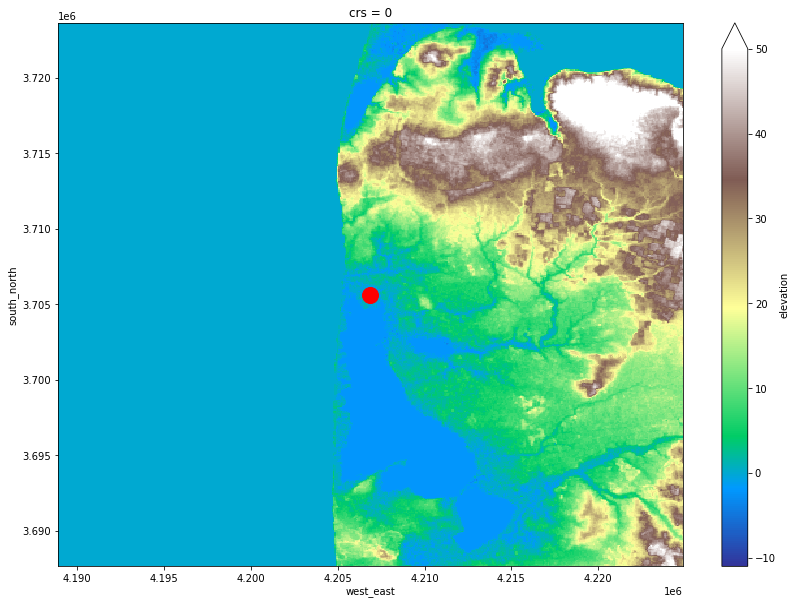

In [40]:
# Plot the elevation
elev.plot(x='west_east', 
          y='south_north', 
          cmap='terrain', 
          vmin=-11, 
          vmax=50, 
          figsize=(14, 10))

# Add the Høvsøre mast location to the plot
plt.plot(loc_x, loc_y, 'or', ms=16)

# Define the plot extent
plt_extent = 18000.0

# Set the plot extent
plt.xlim([loc_x - plt_extent, loc_x + plt_extent])
plt.ylim([loc_y - plt_extent, loc_y + plt_extent]);

Denmark is flat - no surprise. But we can clearly see the coastline of Jutland stretching north-south.

### Roughness data (CORINE Landuse)
Next up is the surface roughness lengths. Here we start from the a roughness map that was created based on the CORINE 2018 landuse dataset, using using a lookup table. The roughness map is provided as a GeoTiff file `rough.tif`, which is a common format in the GIS community. Conviniently, the CORINE dataset is using the European grid projection by default. 

Even though this data is stored to disk as a roughness value, when it is read into PyWAsP it is converted to a landcover map with a corresponding landcover lookup table. This is done to allow for easy manipulation of the different roughness values without having to manipulate the map itself. It also opens up for the possibility to include displacement heights and other relevant parameters, which will be explored more in Tutorial 3.

> **GeoTiff note**: GeoTiff files do not have multiple variables, therefore, `.tif` files open as `xarray.DataArray`' objects not `xarray.Dataset`'s, so we do not need to select the roughness data variable.

In [43]:
# Open rastermap of roughness lengths
landcover, lut = pw.read_rastermap('data/rough.tif', crs='EPSG:3035', map_type='roughness')
print(landcover)

<xarray.DataArray 'landcover' (south_north: 800, west_east: 800)>
array([[1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       ...,
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.]])
Coordinates:
  * south_north  (south_north) float64 3.666e+06 3.666e+06 ... 3.746e+06
  * west_east    (west_east) float64 4.167e+06 4.167e+06 ... 4.247e+06 4.247e+06
    crs          int64 0
Attributes:
    long_name:     Land Cover ID
    units:         
    grid_mapping:  crs


The landuse table consists of a double nested dictionary, so you can change a value by using a command such as `lut[9][z0] = 0.25`, which would change the roughness length (z0) of the landuse with ID 9 to a value of 0.25.

In [45]:
print(lut)

id = LanduseID
z0 = Roughness length (m)
d = Displacement height (m)
desc = Description
id	z0	d	desc
1	0.0000	0.0	
2	0.0030	0.0	
3	0.0200	0.0	
4	0.0300	0.0	
5	0.0500	0.0	
6	0.1000	0.0	
7	0.1500	0.0	
8	0.2000	0.0	
9	0.3000	0.0	
10	0.4000	0.0	
11	0.5000	0.0	
12	0.7000	0.0	
13	0.8000	0.0	
14	1.0000	0.0	
15	1.1000	0.0	
16	1.2000	0.0	



Next, let us visualize the roughness data, although remember the values on this chart will correspond to the landcover id, not to the roughness itself.

We have selected a colormap that has blue as its first color, since our first ID is water, however the other colors don't necessarily correspond to the landuse classification that they correspond to. You could do more to specify the different colors by manipulating the colormap provided by Matplotlib.

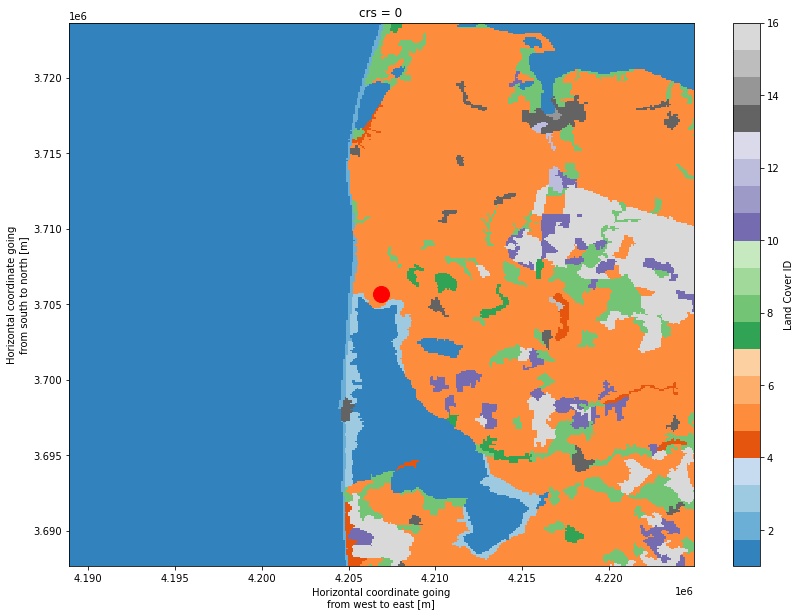

In [46]:
# Plot log of surface roughness lengths
cs = landcover.plot(cmap='tab20c', figsize=(14, 10))

# Add the Høvsøre mast location
plt.plot(loc_x, loc_y, 'or', ms=16)

# Set the plot extent
plt.xlim([loc_x - plt_extent, loc_x + plt_extent])
plt.ylim([loc_y - plt_extent, loc_y + plt_extent]);

Again, we see the coastline clearly, and the water bodies south of the Høvsøre mast. To the east the plantation "Klosterhede plantage" is seen and north of it the city of "Lemvig". 

## SITE EFFECTS

The terrain data are used to calculate site effects used to generalize the observed wind climate ("going up" in WAsP lingo) and to downscale to nearby locations ("going down"). 

The site effects are:

 - Orographic speed-up (by sector)
 - Internal boundar layer speed-up (by sector)
 - Effective upstream surface roughness (by sector)

> **__pywasp note__** WAsP includes site effects due to obstacles, but we will not consider those here

### Create TopographyMap object
Let us investigate the site effects at the site. First we need to read in the raster data as `pywasp` `RasterMap` objects. This will allow us to convert the rasters to vectors, which is the most common data format used for terrain data in WAsP.

> **__pywasp note__** `pywasp` can work with raster maps directly, but it is recommended to convert them to vectors first

We will use `elev.tif` for the elevation instead of `elev.nc`, since the classmethod we will use `pywasp.RasterMap.from_file` currently expects a `.tif` file. The classmethod expects a `MapType` as the second argument, to know what kind of raster is being opened. Lastly, we will pass the proper epsg number as a keyword argument.  


To convert the rasters, the `pywasp.io.rastermap_to_vectormap` function is used. 

> **pywasp note**: conversion to vector maps is a neccessary step for roughness data, and recommended when you need to reproject elevation data. 

In [47]:
elev_map = pw.io.rastermap_to_vectormap(elev)

The vectormap is a `geopandas.GeoDataFrame`. Let's inspect it.

In [48]:
print(elev_map)

           elev                                           geometry
0      0.000000  LINESTRING (4205015.500 3686038.750, 4205015.5...
1      0.000000  LINESTRING (4226450.500 3718266.000, 4226450.5...
2      0.000000  LINESTRING (4210436.500 3724936.250, 4210412.0...
3      0.000000  LINESTRING (4209887.000 3724936.250, 4209812.0...
4      0.000000  LINESTRING (4209737.000 3724936.250, 4209662.5...
...         ...                                                ...
1214  62.299995  LINESTRING (4225348.500 3715792.750, 4225401.0...
1215  71.199997  LINESTRING (4218955.500 3718246.000, 4218881.0...
1216  71.199997  LINESTRING (4221264.000 3718191.000, 4221279.0...
1217  71.199997  LINESTRING (4222448.500 3718041.000, 4222478.0...
1218  71.199997  LINESTRING (4223044.000 3718116.000, 4223078.0...

[1219 rows x 2 columns]


The `GeoDataFrame` contains two columns of data "elev" and "geometry". The "elev" column holds the elevation height values and the "geometry" columns is a `shapely.geometry.LINESTRING` holding the spatial information of each elevation line.

We can use the builtin `.plot` method to visualize the elevation contours.

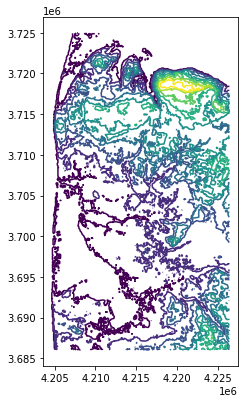

In [49]:
elev_map.plot(column='elev', cmap='viridis', figsize=(3.5, 8))

For the roughness data, a similiar conversion step is used. However, instead of just returning a vectormap of rougness-change lines, for maps of "roughness" type the function returns a vectormap of landuse indicies and a look-up table.


In [50]:
lu_map, lu_table = pw.io.rastermap_to_vectormap(landcover, lutable=lut)

The lookup table contains information about each landuse class, and is identical to the one that we passed in.


In [51]:
print(lu_table)

id = LanduseID
z0 = Roughness length (m)
d = Displacement height (m)
desc = Description
id	z0	d	desc
1	0.0000	0.0	
2	0.0030	0.0	
3	0.0200	0.0	
4	0.0300	0.0	
5	0.0500	0.0	
6	0.1000	0.0	
7	0.1500	0.0	
8	0.2000	0.0	
9	0.3000	0.0	
10	0.4000	0.0	
11	0.5000	0.0	
12	0.7000	0.0	
13	0.8000	0.0	
14	1.0000	0.0	
15	1.1000	0.0	
16	1.2000	0.0	



In [52]:
print(lu_map)

      id_left  id_right                                           geometry
0         2.0       1.0  LINESTRING (4205000.000 3686700.000, 4204900.0...
1         4.0       2.0  LINESTRING (4203300.000 3669800.000, 4203300.0...
2         8.0       4.0  LINESTRING (4204200.000 3666900.000, 4204100.0...
3         8.0       7.0  LINESTRING (4203900.000 3665700.000, 4203900.0...
4         7.0       1.0  LINESTRING (4204600.000 3665700.000, 4204600.0...
...       ...       ...                                                ...
1723      5.0       2.0  LINESTRING (4213300.000 3745700.000, 4213300.0...
1724      8.0       5.0  LINESTRING (4239400.000 3745500.000, 4239700.0...
1725     13.0      10.0  LINESTRING (4223200.000 3745600.000, 4223300.0...
1726      8.0       1.0  LINESTRING (4239500.000 3745700.000, 4239500.0...
1727     13.0       5.0  LINESTRING (4223200.000 3745700.000, 4223200.0...

[1728 rows x 3 columns]


The vectormap contains a "geometry" column and landuse indicies "id_left" and "id_right" for each line. 

Let us visualize the landuse-change contours.

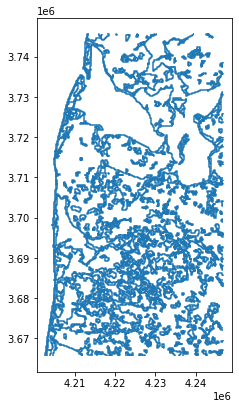

In [53]:
lu_map.plot(figsize=(3.5, 8))

We can now use our elevation and landuse vectormaps to construct a `pywasp` `TopographyMap` object to calculate site effects. 

In [54]:
topo_map = pw.wasp.TopographyMap(elev_map, lu_map, lu_table)

In [55]:
topo_map

Roughness map

              PyWAsP map
              Contains 1728 contour lines
              It has the extent of Bounds: (4202700.0, 3665700.0) (4246800.0, 3745700.0)
CRS: PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",10,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",4321000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",3210000,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing (Y)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting (X)",east,ORDER[2],LENGTHUNIT["metre",1]],U

### Roughness Rose

We will first explore the roughness elements upstream from the the Høvsøre mast for each of 12 sectors. We can do this by using `get_rou_rose_pt` method of `topo_map`, and pass in the location of the mast and the number of sectors we would like to use. It requires a WAsP configuration object (`pywasp.wasp.Config`) that stores the parameters. We will simply use the default values.

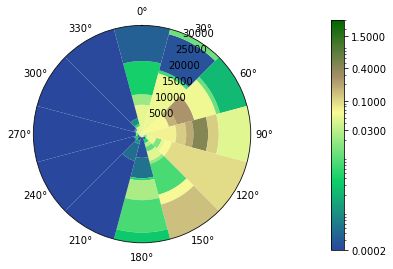

In [56]:
conf = pw.wasp.Config()
rou_rose = topo_map.get_rou_rose_pt(loc_x, loc_y, 12, conf,topo_map.get_elev_rose(loc_x, loc_y, 12, conf))
rou_rose.plot()

The open sea is clearly present to the west, and we see that the rose corresponds well to what we would expect from the roughness elements we saw in the map.

### Output Locations

Next up we will take a look at the site effects for the whole area surrounding the Høvsøre mast. We need to tell `pywasp` what locations we would like to calculate the site effects at. This is done by creating a `xarray.Dataset` with dimensions (`west_east`, `south_north`, and `height`) with coordinates values where we want to calculate the effects. Since this is a common need in PyWAsP, a convience function in `pywasp.spatial` called `create_dataset` has been created for this purpose.

We tell `pywasp` that the projection of `west_east`, `south_north` coordinates are in the European grid projection by adding the coordinate reference system attribute `crs="EPSG:3035"`. 

> **__numpy note__** we use `numpy`'s `array` and `linspace` array constructors to pass in data arrays to `xarray.Dataset`. `numpy.array` simply takes a list of values and creates an array. `numpy.linspace` takes a start and an end value, and the number of values to include linearly between them (including both ends). 
 `np.linspace(0, 5, 6)` = `np.array([0, 1, 2, 3, 4, 5])`


In [57]:
output_locs = pw.spatial.create_dataset(
    np.linspace(loc_x-20000.0, loc_x+20000.0, 41).squeeze(),
    np.linspace(loc_y-20000.0, loc_y+20000.0, 41).squeeze(),
    np.array([100.0]),
    crs="EPSG:3035"
)
print(output_locs)

<xarray.Dataset>
Dimensions:      (height: 1, south_north: 41, west_east: 41)
Coordinates:
  * height       (height) float64 100.0
  * south_north  (south_north) float64 3.686e+06 3.687e+06 ... 3.726e+06
  * west_east    (west_east) float64 4.187e+06 4.188e+06 ... 4.226e+06 4.227e+06
    crs          int64 0
Data variables:
    output       (height, south_north, west_east) float64 0.0 0.0 ... 0.0 0.0


### Site Effects Calculation

To get the site effects we will use the `get_site_effects` method from our `topo_map` object. 

`get_site_effects` expects the unique `west_east` and `south_north` values, the number of sectors, and the height above ground, and the configuration object.

> **__pywasp note__** depending on the number of locations, `get_site_effects` may take some time to complete

In [58]:
site_effects = topo_map.get_site_effects(output_locs, conf, 12)
print(site_effects)

<xarray.Dataset>
Dimensions:              (height: 1, sector: 12, south_north: 41, west_east: 41)
Coordinates:
    crs                  int64 0
  * sector               (sector) float64 0.0 30.0 60.0 ... 270.0 300.0 330.0
  * height               (height) float64 100.0
  * south_north          (south_north) float64 3.686e+06 3.687e+06 ... 3.726e+06
  * west_east            (west_east) float64 4.187e+06 4.188e+06 ... 4.227e+06
Data variables:
    z0meso               (sector, height, south_north, west_east) float32 0.00020000007 ... 0.0024514326
    slfmeso              (sector, height, south_north, west_east) float32 0.0 ... 0.44662356
    displ                (sector, height, south_north, west_east) float32 0.0 ... 0.0
    user_def_speedups    (sector, height, south_north, west_east) float32 1.0 ... 1.0
    orographic_speedups  (sector, height, south_north, west_east) float32 1.0000043 ... 1.0000451
    obstacle_speedups    (sector, height, south_north, west_east) float32 1.0 ... 1.0


The site effects dataset is made up of following variables:

 - `z0meso`: effective upstream roughness by sector
 - `slfmeso`: effective upstream sea-land-fraction by sector              
 - `displ`: displacement height by sector
 - `user_def_speedups`: user defined speed-ups (as factor)
 - `orographic_speedups`: speed-ups due to orography (as factor)
 - `obstacle_speedups`: obstacle induced speed-ups (as factor)
 - `roughness_speedups`: speed-ups due to roughness changes (as factor)
 - `user_def_turnings`: user defined wind turning (in degrees)
 - `orographic_turnings`: wind turning due to orography (in degrees)
 - `obstacle_turnings`: wind turning due to obstracels (in degrees)
 - `roughness_turnings`: wind turning due to roughness changes (in degrees)
 - `site_elev`: surface elevation 
 - `rix`: ruggedness index
 - `dirrix`: sector wise ruggedness index 

#### Plotting z0meso

Let us take a look at the effective upstream surface roughness `z0meso` for the eastern sector (`sector=90.0`). We select this sector using `xarray`'s built-in selection method `.sel`. It is quite flexible and can take a single value `.sel(sector=90.0)` or a slice `.sel(sector=slice(0.0, 180.0))`. Here we just use `90.0`.  

We plot `z0meso` using `xarray`'s `.plot` method. We pass in `figsize=(14, 10)` to increase the size of the map.

We also plot the roughness map itself as a series of contour elements, to highlight the boundaries of the main roughness elements on the same map we also plot `rgh`. To get contour lines instead of filled contours, we explicitly ask for `.plot.contour` and tell it we want the colors to be `white` and the linestyles full (`-`).

We plot the location of the mast as before.

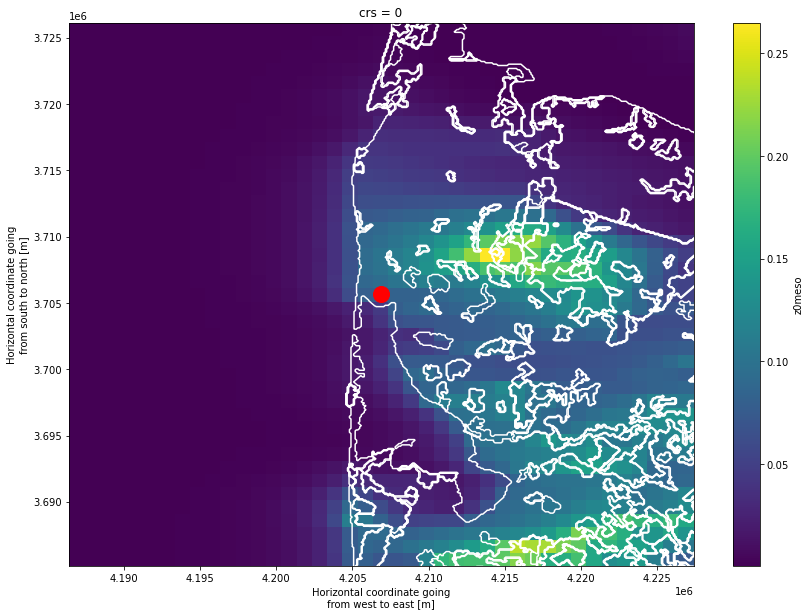

In [59]:
site_effects['z0meso'].sel(sector=90.0).plot(figsize=(14, 10))
landcover.plot.contour(colors='white',add_labels=True, linestyles='-')
plt.plot(loc_x, loc_y, 'or', ms=16);



We clearly see the imprent of the plantation north-east of Høvsøre. We also see how the effective upstream roughness stays well above 0 for some distance offshore.

#### Plotting Roughness Change Speedups

Next, let us investigate the speed-ups due to roughness changes. 

Instead of using `.sel` to select by coordinate value, we will select by index using `.isel`. To get the same easterly direction we need to select sector index `3` - counting from `0`. Python uses zero based indexing. `xarray` uses the name of the `DataArray` as the colorbar label, we can rename it to change that as well.

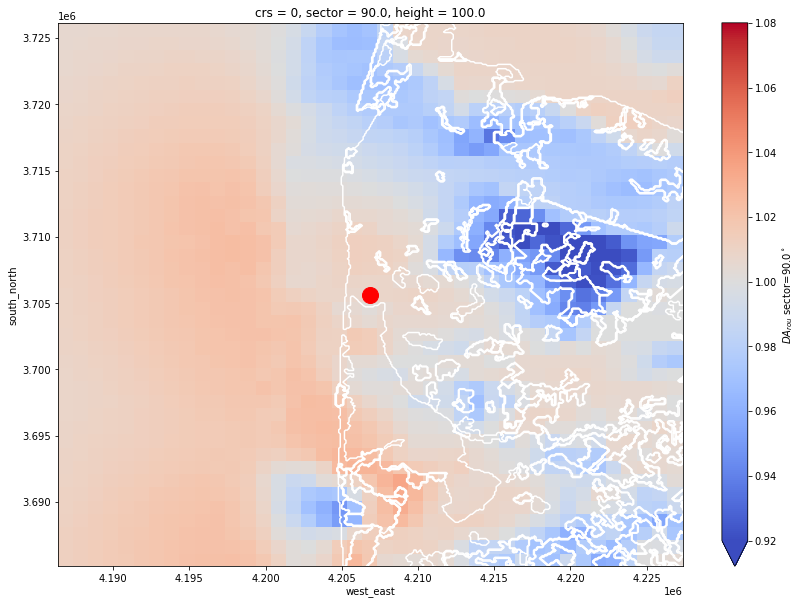

In [60]:
(site_effects['roughness_speedups']
   .isel(sector=3)
   .rename(r'$DA_{rou}$ sector=90.0$^\circ$')
   .plot(vmin=0.92, vmax=1.08, cmap='coolwarm', figsize=(14, 10)))

landcover.plot.contour(colors='white', add_labels=False, linestyles='-')
plt.plot(loc_x, loc_y, 'or', ms=16);

## Generalization and downscaling with PyWAsP
Now it is time to actually generalize our observed wind climate and then downscale it to our chosen locations. Generalization involves calculating the wind speed for predefined surface roughnesses and heights above ground. So the first thing we need to do is chose these roughness and height classes.

`pywasp` has functions to make it easier to chose sensible roughness and height values for generalization `pywasp.wasp.set_hgts` and `pywasp.wasp.set_z0s` based on the source and target heights and effective roughnesses. 

Since we are prediction at 100 m, the default values of 10.0, 50.0, 100.0, 150.0, and 200.0 works fine.

In [61]:
gen_heights = pw.wasp.set_hgts()
print(gen_heights)

[ 10.  25.  50. 100. 200.]


For roughness we can pass in the z0meso values to get an appropriate list of values.


In [62]:
gen_roughnesses = pw.wasp.set_z0s(site_effects['z0meso'].values)
print(gen_roughnesses)

[0.         0.00133419 0.00890032 0.05937363 0.39607871]


The generalization is done with the generalize function from pywasp's wasp module. It takes the binned wind climate (bwc), our topographic map (topo_map), the roughness and height classes, and finally the configuration object (conf). 

In [63]:
gwc = pw.wasp.generalize(bwc, topo_map, conf, gen_roughnesses, gen_heights)
print(gwc)

<xarray.Dataset>
Dimensions:        (gen_height: 5, gen_roughness: 5, point: 1, sector: 12)
Coordinates:
    west_east      (point) float64 4.207e+06
    height         (point) float64 100.0
    crs            int64 0
    south_north    (point) float64 3.706e+06
  * sector         (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
  * gen_roughness  (gen_roughness) float64 0.0 0.001334 0.0089 0.05937 0.3961
  * gen_height     (gen_height) float64 10.0 25.0 50.0 100.0 200.0
Dimensions without coordinates: point
Data variables:
    A              (sector, gen_height, gen_roughness, point) float32 4.185647 ... 5.535669
    k              (sector, gen_height, gen_roughness, point) float32 1.3886719 ... 1.6308594
    wdfreq         (sector, gen_roughness, point) float32 0.026028784 ... 0.020098412
Attributes:
    header:   Høvsøre observed wind climate EPSG:3035


The generalized wind climate contains weibull parameters (`A` and `k`) for each location, sector, and height and roughness class.    

## Predicted Wind Climates

Now, let us calculate the wind climate at the location we have defined. The `pywasp.wasp` module provides two ways of doing this: `downscale` and `get_wasp_down`. The latter assumes site effects that have already been calculated, while the first one will start by calculating them. Since we have already calculated the site effects, we will use `get_wasp_down`. The function requires passing a `genwc_interp` method. Two choices are available: `'nearest'` and `'natural'`. This is important when several generalized wind climates are present and will tell `pywasp` how to interpolate them to the location. Since just one wind climate is present in this study, the same generalized wind climate will be used everywhere. 

After calculating the predicted wind climates at the output locations, we will enrich it by usefull derived quantities: the omnidirectional mean wind speed and power density, however, this needs the elevation field from the site_effects added to the predicted wind climates. In Tutorial 4, we will show a way to calculate all of this in one pass.

In [64]:
pwc = pw.wasp.get_wasp_down(gwc, site_effects, conf, genwc_interp='nearest')

In [65]:
print(pwc)

<xarray.Dataset>
Dimensions:      (height: 1, sector: 12, south_north: 41, west_east: 41)
Coordinates:
  * sector       (sector) float64 0.0 30.0 60.0 90.0 ... 240.0 270.0 300.0 330.0
    crs          int64 0
  * height       (height) float64 100.0
  * south_north  (south_north) float64 3.686e+06 3.687e+06 ... 3.726e+06
  * west_east    (west_east) float64 4.187e+06 4.188e+06 ... 4.226e+06 4.227e+06
Data variables:
    A            (sector, height, south_north, west_east) float32 5.3622622 ... 7.384323
    k            (sector, height, south_north, west_east) float32 1.4316406 ... 1.5488281
    wdfreq       (sector, height, south_north, west_east) float32 0.026006794 ... 0.020929575
    A_tot        (height, south_north, west_east) float32 11.081547 ... 10.857785
    k_tot        (height, south_north, west_east) float32 2.2675781 ... 2.3066406


The predicted wind climate contains the predicted probability density functions at the output locations. To enrich the wind climate with derived quantities, such as the mean wind speed or power density, the pywasp.wasp.add_met_fields can be used.


In [66]:
pwc['elev'] = site_effects['elev']
pwc = pw.wasp.add_met_fields(pwc)
print(pwc)

<xarray.Dataset>
Dimensions:            (height: 1, sector: 12, south_north: 41, west_east: 41)
Coordinates:
  * sector             (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
    crs                int64 0
  * height             (height) float64 100.0
  * south_north        (south_north) float64 3.686e+06 3.687e+06 ... 3.726e+06
  * west_east          (west_east) float64 4.187e+06 4.188e+06 ... 4.227e+06
Data variables:
    A                  (sector, height, south_north, west_east) float32 5.3622622 ... 7.384323
    k                  (sector, height, south_north, west_east) float32 1.4316406 ... 1.5488281
    wdfreq             (sector, height, south_north, west_east) float32 0.026006794 ... 0.020929575
    A_tot              (height, south_north, west_east) float64 11.08 ... 10.86
    k_tot              (height, south_north, west_east) float64 2.268 ... 2.307
    elev               (height, south_north, west_east) float32 0.0 0.0 ... 0.0
    wspd_sector        (sector

Finally the predicted wind climates around the site have been calculated. Let us plot the omnidirectional quantities: Weibull A and k, the mean wind speed, and the mean power density.

We will set up a plotting canvas consisting of four subplots using some `matplotlib` functionality. We define the subplots and pass their axes to the `xarray` plotting method when plotting the four quantities. Finally we add the roughness outlines and location of the mast.

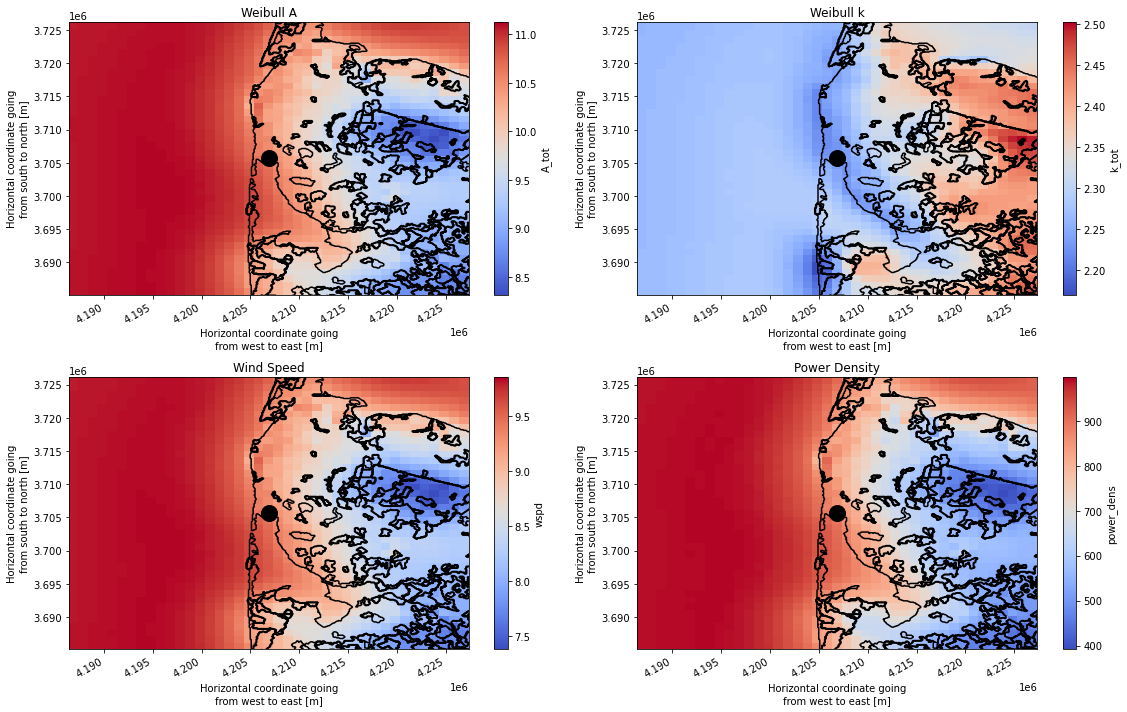

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ax1, ax2, ax3, ax4 = axes.flat

variables = ['A_tot', 'k_tot', 'wspd', 'power_dens']

for var, ax in zip(variables, axes.flat):
    pwc[var].isel(height=0).plot(ax=ax, cmap='coolwarm')

    landcover.plot.contour(colors='black', linestyles='-', ax=ax)
    ax.plot(loc_x, loc_y, 'ko', ms=16)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax1.set_title("Weibull A")
ax2.set_title("Weibull k")
ax3.set_title("Wind Speed")
ax4.set_title("Power Density");

fig.tight_layout()    